#Carregandos dados e bibliotecas

In [1]:
# Baixando
!pip install -U -q PyDrive
!pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 1.7 MB/s 
     |████████████████████████████████| 101 kB 3.7 MB/s 
     |████████████████████████████████| 50 kB 3.4 MB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 45.4 MB/s 
     |████████████████████████████████| 965 kB 45.6 MB/s 
     |████████████████████████████████| 943 kB 55.9 MB/s 
     |████████████████████████████████| 749 kB 54.3 MB/s 
     |████████████████████████████████| 133 kB 69.7 MB/s 
     |████████████████████████████████| 28.5 MB 61.5 MB/s 
     |████████████████████████████████| 232 kB 57.8 MB/s 
     |████████████████████████████████| 96 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 45.3 MB/s 
     |██████████████████████

In [2]:
# Importando bibliotecas
import pandas as pd
import numpy as np

# Bibliotecas para carregamento e tratamentos de dados
from pydrive.auth import GoogleAuth
from dataprep.eda import create_report
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google_drive_downloader import GoogleDriveDownloader as gdd
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para modelagem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download dos dados
!gdown 1yKYkbBl30GQLdDDXOPMpnno7HiES26NT

Downloading...
From: https://drive.google.com/uc?id=1yKYkbBl30GQLdDDXOPMpnno7HiES26NT
To: /content/data.csv
100% 1.60G/1.60G [00:13<00:00, 121MB/s]


In [5]:
#Lendo os dados do arquivo
df = pd.read_csv('/content/data.csv')

# Preparação de Dados

###Tratamento dos dados

In [6]:
#Label encoding cod_rating to cod_rating_numeric
df['cod_rating_numeric'] = (df['cod_rating'].replace('HH',1)
                                              .replace('H',2)
                                              .replace('G',3)
                                              .replace('F',4)
                                              .replace('E',5)
                                              .replace('D',6)
                                              .replace('c',7)
                                              .replace('B',8)
                                              .replace('A',9)
                                              .replace('AA',10)
                                              .replace(np.nan, 0))

In [7]:
#Seleciona somente clientes
preframe = df.loc[df['cod_rating_numeric'] != 0]

###Feature Engeneering

In [8]:
#Definindo o dataset com clientes e com o feature engineering selecionado
df_new_all = preframe.fillna(0)

In [9]:
#Entendimento das Features por meio de uma matriz de correlação
matriz_corr = df_new_all.corr().style.background_gradient(cmap='coolwarm')

In [10]:
#Seleção das Features
df_new_focus = df_new_all[['vlr_credito',	'vlr_saldo',	'num_atend_atrs',	'num_produtos',	'num_atend',	'qtd_oper',	'qtd_reclm',	'ind_atrito',	'ind_engaj']]

In [11]:
#ordenando o dataset pelas colunas com IQR diferente de 0 (colunas relevantes)
df_util= df_new_focus.sort_values(by=['vlr_saldo','qtd_oper'])

###Setando a Safra Artificial

In [12]:
#Calculando o tamanho da amostra
x = 2.5/100
rejeicao = int(6218119 * x)
rejeicao

155452

In [13]:
# Aplicando confiança de 90%
df_wth_out_outliers = df_util.iloc[ 155452 : -155452 ]

In [14]:
# Seleciona somente os atritados
df_atr = df_wth_out_outliers.loc[df['ind_atrito'] == 1]
x = df_atr

In [15]:
#Seleciona somente os não atritados
df_natr = df_wth_out_outliers.loc[df['ind_atrito'] != 1]
ys = df_natr.sample(frac=1)

In [16]:
#Setando para 30/70
df_natr = df_wth_out_outliers.loc[df['ind_atrito'] != 1]
y1 = ys.sample(frac=1).head(6062)

In [17]:
SafraArtificial = x.append(y1)

# Modelo Final


###Algoritmo usado:

####**Random Forest**

Algoritmo de classificação, que **seleciona uma amostra de dados do conjunto de treinamento** e  **n variáveis aleatórias** em que estas serão submetidas a cálculos para a criação de um novo nó, e nesse nó o processo dito se repete.

###Safra usada:

A safra usada foi a de 30% atritados e 70% não atritados. No modelo original, mais de 99% dos clientes eram não atritados, consequentemente se o modelo tivesse de predizer se o cliete tinha atrito com o banco ou não, ele diria em quase todas as ocasiões que cliente é não atritado. Com uma proporção mais razoável, é possível obter ambos resultados de modo mais uniforme, o que reflete melhor a realidade.


###Métricas usadas:

Precisão, Revocação, F1-Score e Acurácia.




In [18]:
# Lendo os dados do arquivo de safra artificial 
data_safra_artificial = SafraArtificial

###Divisão do modelo em teste e treino

In [19]:
# Dropa a coluna de target
x = data_safra_artificial.drop(['ind_atrito'], axis = 1)
y = data_safra_artificial['ind_atrito']

In [20]:
# Separa o conjunto teste do de treinamento e o de treinamento recebe 70% dos dados
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.3,
                                                    random_state = 42)

###Aplicação do algoritmo de Random Forest

In [21]:
# treinamento do modelo pelo algoritmo random forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [22]:
# teste com o modelo
y_predrf = rfc.predict(x_test)

###Avaliação do Modelo




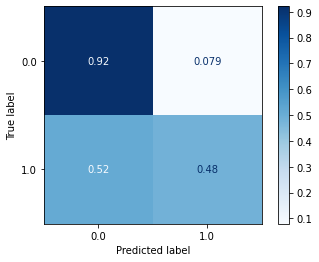

In [23]:
# Aplicação da matriz de confusão
_ = plot_confusion_matrix(rfc, x_test, y_test, cmap='Blues', normalize='true')

In [24]:
# Aplicação de todas as métricas
print(classification_report(y_test, y_predrf))

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1806
         1.0       0.74      0.48      0.59       840

    accuracy                           0.78      2646
   macro avg       0.77      0.70      0.72      2646
weighted avg       0.78      0.78      0.77      2646



# Exportando - Modelo

In [25]:
# Import dump para usar como exportar
from joblib import dump


# Dump exporta o modelo para a pasta 'export_model' que está no drive
dump(rfc,'/content/drive/MyDrive/modelo_oficial')

['/content/drive/MyDrive/modelo_oficial']